In [53]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# 1.Read File

In [54]:
data = pd.read_csv('/Users/check4068/Desktop/Product Sense/3.Employee Retention/Employee_Rentation.csv', parse_dates=['join_date', 'quit_date'])
data.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   24702 non-null  int64         
 1   employee_id  24702 non-null  float64       
 2   company_id   24702 non-null  int64         
 3   dept         24702 non-null  object        
 4   seniority    24702 non-null  int64         
 5   salary       24702 non-null  float64       
 6   join_date    24702 non-null  datetime64[ns]
 7   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 1.5+ MB


# 2. Data Visualization

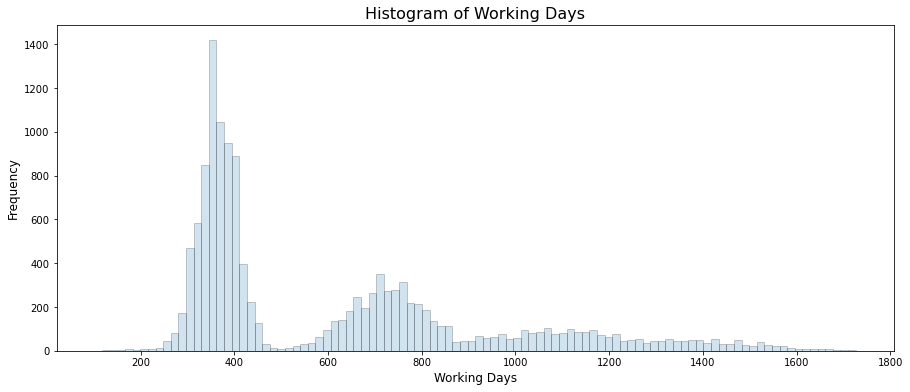

In [56]:
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

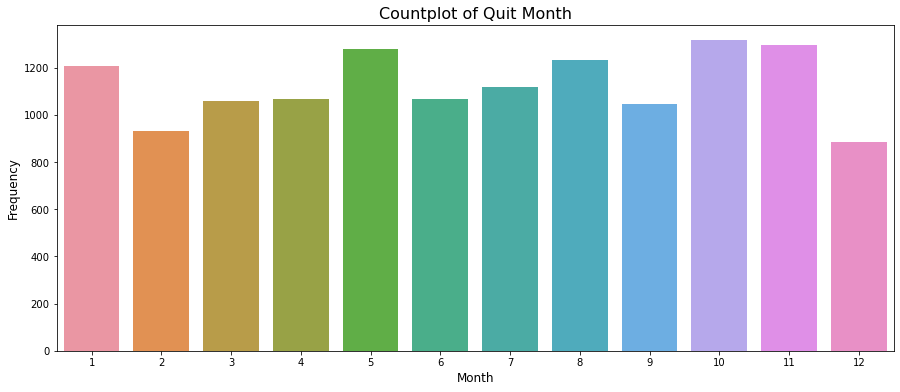

In [57]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

# 3. Feature Engineering

In [58]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)

subset.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


# 4. Machine Learning

In [59]:
# Label encoder
le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(subset['dept'])
train_y = subset['quit'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [60]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

# 5.Feature importance

In [61]:
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97439
seniority  | 0.02561
company_id | 0.00000
dept       | 0.00000


In [50]:
feat_importances = pd.DataFrame({"name":train_x.columns,"coef":clf.feature_importances_})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
2,salary,0.97439,0.97439
1,seniority,0.02561,0.02561
0,company_id,0.00000,0.00000
3,dept,0.00000,0.00000


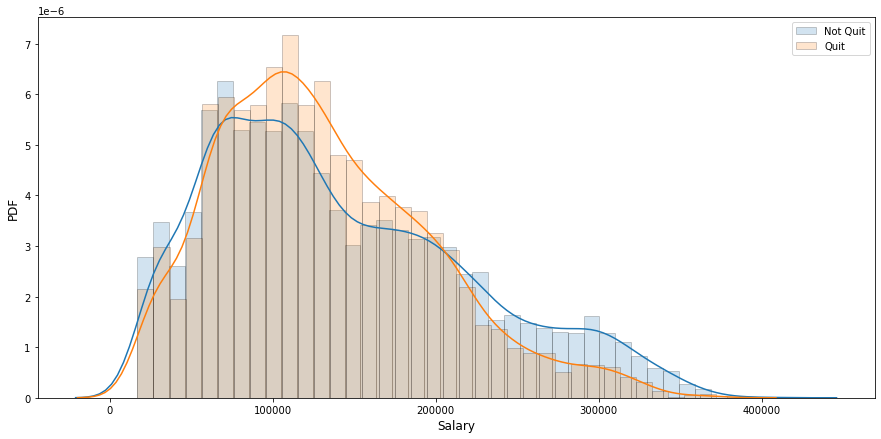

In [17]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['quit']==0]['salary'], 
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['quit']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()


# Summary
1.  
Given how important is salary, I would definitely love to have as a variable the salary the employee
who quit was offered in the next job. 
Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

2.  
The major findings are that employees quit at year anniversaries or at the beginning of the year. 
Both cases make sense. Even if you don’t like your current job, 
you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait.
Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3.  
Employees with low and high salaries are less likely to quit.
Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, 
so they have a hard time finding a new job.
